# Transfer learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture wich has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## Downloading and becoming one with the data

In [1]:
# Get data (10% of 10 food classes from Food101)
import zipfile
import wget

# Download the data
# wget.download("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip")

# Unzip the downloaded file
# zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
# zip_ref.extractall()
# zip_ref.close()

In [2]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches. (Since that class is deprecated I'm using `image_dataset_from_directory`)

In [3]:
# Setup data inputs
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# train_datagen = ImageDataGenerator(rescale=1/255.)
# test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
'''
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
'''

# New way of seting up train and test data
# scaling_layer = tf.keras.layers.Rescaling(1/255.)

train_data_10_percent = image_dataset_from_directory(directory=train_dir,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMAGE_SHAPE,
                                                     seed=SEED,
                                                     label_mode="categorical")

# train_data_10_percent = train_data_10_percent.map(lambda x, y: (scaling_layer(x), y))

print("Testing images:")
'''
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")
'''

test_data = image_dataset_from_directory(directory=test_dir,
                                         batch_size=BATCH_SIZE,
                                         image_size=IMAGE_SHAPE,
                                         seed=SEED,
                                         label_mode="categorical")
# test_data = test_data.map(lambda x, y: (scaling_layer(x), y))

Training images:
Found 750 files belonging to 10 classes.
Testing images:
Found 2500 files belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [4]:
# Create TensorBoard callback (functionalized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


> 🔑 **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come ffrom TensorFlow HUb.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:  
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [5]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [6]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [8]:
# Let's make our create_model() function to create a model from a URL
def create_model(model_url: str, num_classes: int=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
            should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature
        extractor layer and Dense output layer with num_classes output neurons.
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,  # freeze the already learned patterns
                                             name="feature_extraction_layer")  # maybe needs input_shape

    # Adding a scaling layer since I don't use ImageDataGenerator
    scaling_layer = tf.keras.layers.Rescaling(1/255., input_shape=IMAGE_SHAPE + (3,))

    # Create our own model
    model = tf.keras.Sequential([
        scaling_layer,
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

In [9]:
# Get number of labels
# image_batch, labels_batch = next(iter(train_data_10_percent))
# len(image_batch[0]), len(labels_batch[0])

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [10]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=len(train_data_10_percent.class_names))

In [11]:
# Compile our ResNet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [12]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221007-073109
Epoch 1/5
24/24 [==============================] - 50s 2s/step - loss: 1.8434 - accuracy: 0.3653 - val_loss: 1.1226 - val_accuracy: 0.6460
Epoch 2/5
24/24 [==============================] - 48s 2s/step - loss: 0.8747 - accuracy: 0.7493 - val_loss: 0.8364 - val_accuracy: 0.7232
Epoch 3/5
24/24 [==============================] - 48s 2s/step - loss: 0.6137 - accuracy: 0.8200 - val_loss: 0.7477 - val_accuracy: 0.7644
Epoch 4/5
24/24 [==============================] - 48s 2s/step - loss: 0.4675 - accuracy: 0.8747 - val_loss: 0.6732 - val_accuracy: 0.7836
Epoch 5/5
24/24 [==============================] - 48s 2s/step - loss: 0.3638 - accuracy: 0.9213 - val_loss: 0.6615 - val_accuracy: 0.7808


Wow!

That. Is. Incredible. Our transfer learning feature extractor model outperformed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [13]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...

import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
        history: TensorFlow History object.

    Returns:
        Plots of training/validation loss and accuracy metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))  # how many epochs did we run for?

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

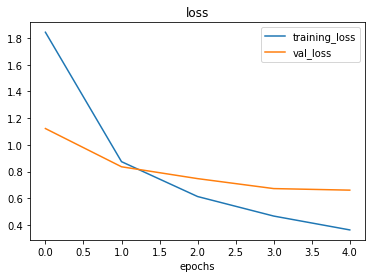

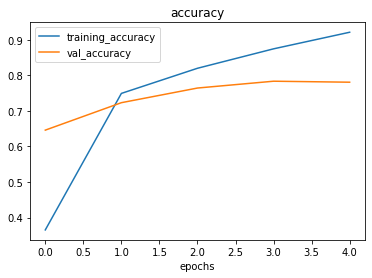

In [14]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

**Note:** Details on EfficientNet - https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html

In [15]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(efficientnet_url,
                                  num_classes=len(train_data_10_percent.class_names))

In [16]:
# Compile our EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [17]:
# Let's fit our EfficientNet model to the data (10 percent of 10 classes)
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[
                                                create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                            experiment_name="efficientnetB0")
                                              ])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20221007-073517
Epoch 1/5
24/24 [==============================] - 39s 2s/step - loss: 1.8246 - accuracy: 0.4613 - val_loss: 1.2555 - val_accuracy: 0.7360
Epoch 2/5
24/24 [==============================] - 35s 2s/step - loss: 1.0275 - accuracy: 0.7933 - val_loss: 0.8391 - val_accuracy: 0.8228
Epoch 3/5
24/24 [==============================] - 36s 2s/step - loss: 0.7358 - accuracy: 0.8507 - val_loss: 0.6771 - val_accuracy: 0.8496
Epoch 4/5
24/24 [==============================] - 36s 2s/step - loss: 0.5896 - accuracy: 0.8760 - val_loss: 0.5930 - val_accuracy: 0.8624
Epoch 5/5
24/24 [==============================] - 36s 2s/step - loss: 0.5024 - accuracy: 0.9000 - val_loss: 0.5422 - val_accuracy: 0.8720


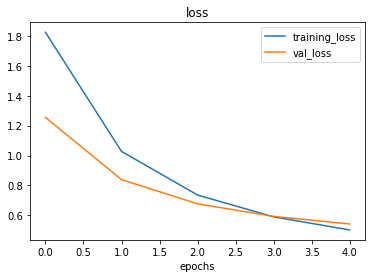

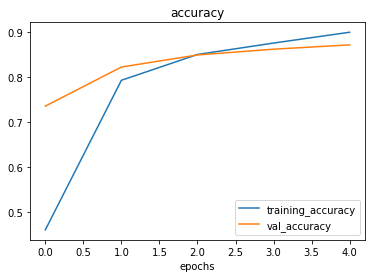

In [18]:
plot_loss_curves(efficientnet_history)

In [19]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [20]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [21]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[1].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes whatsoever (e.g. using ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

**Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

### Show TensorBoard in VsCode:

1. **Select appropriate python interpreter:** Command Palette -> Python Select Interpreter
2. **Start Tensorboard:** command palette -> Python: Launch TensorBoard
3. (For first time) **Install Tensorboard and torch-tb-profiler:** You can do it by just clicking on vs code prompt or manually inside the select python interpreter.
4. **Folder selection:** Select the folder where your TensorBoard log files are stored. By default, the current directory opened in vs code file will be used.

or

%load_ext tensorboard

%tensorboard --logdir <log_dir>